In [ ]:
!pip install tensorflow tensorflow_hub librosa -q


In [ ]:
import os, re, glob, librosa, numpy as np, pandas as pd, tensorflow as tf, tensorflow_hub as hub
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # Import ModelCheckpoint and EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/audio lstm cnn"

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError("RAVDESS not found. Upload it to your Drive under /MyDrive/RAVDESS.")

files = glob.glob(os.path.join(DATASET_DIR, "Actor_*/*.wav"))
print(f"✅ Found {len(files)} audio files.")


✅ Found 1440 audio files.


In [ ]:
EMOTION_MAP = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_emotion(file):
    parts = re.findall(r'\d{2}', os.path.basename(file))
    return EMOTION_MAP.get(parts[2], "unknown") if len(parts) >= 3 else "unknown"

data = [(f, get_emotion(f)) for f in files if get_emotion(f) != "unknown"]
df = pd.DataFrame(data, columns=["path", "emotion"])
print("✅ Total samples:", len(df))
df.head()


✅ Total samples: 1440


,path,emotion
0,/content/drive/MyDrive/audio lstm cnn/Actor_05...,calm
1,/content/drive/MyDrive/audio lstm cnn/Actor_05...,happy
2,/content/drive/MyDrive/audio lstm cnn/Actor_05...,calm
3,/content/drive/MyDrive/audio lstm cnn/Actor_05...,happy
4,/content/drive/MyDrive/audio lstm cnn/Actor_05...,sad


In [ ]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")
print("✅ YAMNet loaded successfully.")


✅ YAMNet loaded successfully.


In [ ]:
def extract_yamnet_embedding(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    waveform = tf.convert_to_tensor(y, dtype=tf.float32)
    _, embeddings, _ = yamnet_model(waveform)
    return np.mean(embeddings.numpy(), axis=0)

X, y = [], []
for p, e in tqdm(zip(df["path"], df["emotion"]), total=len(df)):
    try:
        X.append(extract_yamnet_embedding(p))
        y.append(e)
    except Exception as ex:
        print("Error:", p, ex)

X = np.array(X)
print("✅ Feature shape:", X.shape)


100%|██████████| 1440/1440 [12:49<00:00,  1.87it/s]

✅ Feature shape: (1440, 1024)


In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)
num_classes = len(le.classes_)
print("Classes:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)
print("Train:", X_train.shape, "| Test:", X_test.shape)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Train: (1152, 1024) | Test: (288, 1024)


In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(1024,)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,184 (2.51 MB)

 Trainable params: 658,184 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/best_yamnet_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=70,
    batch_size=32,

    verbose=1
)


Epoch 1/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3597 - loss: 1.6382 - val_accuracy: 0.3121 - val_loss: 1.7592
Epoch 2/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3401 - loss: 1.6432 - val_accuracy: 0.3699 - val_loss: 1.7127
Epoch 3/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3099 - loss: 1.7405 - val_accuracy: 0.3526 - val_loss: 1.7032
Epoch 4/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3458 - loss: 1.6441 - val_accuracy: 0.3410 - val_loss: 1.7454
Epoch 5/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3796 - loss: 1.6141 - val_accuracy: 0.3064 - val_loss: 1.8009
Epoch 6/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3889 - loss: 1.5929 - val_accuracy: 0.3699 - val_loss: 1.6606
Epoch 7/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3636 - loss: 1.6195 - val_accuracy: 0.3642 - val_loss: 1.6761
Epoch 8/70
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3836 - loss: 1.6301 - val_accuracy: 0.3468 - val_loss:

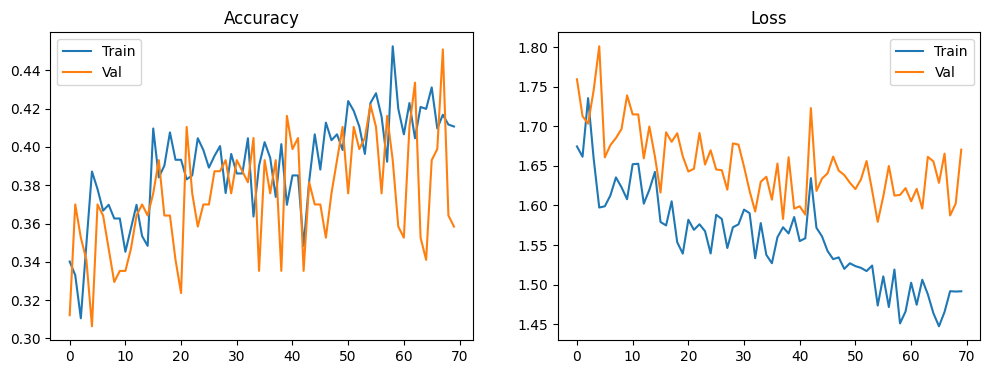

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss'); plt.legend()
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

       angry       0.74      0.51      0.61        39
        calm       0.62      0.13      0.22        38
     disgust       0.64      0.18      0.28        39
     fearful       0.43      0.56      0.49        39
       happy       0.21      0.37      0.27        38
     neutral       0.33      0.05      0.09        19
         sad       0.20      0.47      0.28        38
   surprised       0.45      0.34      0.39        38

    accuracy                           0.35       288
   macro avg       0.45      0.33      0.33       288
weighted avg       0.46      0.35      0.34       288



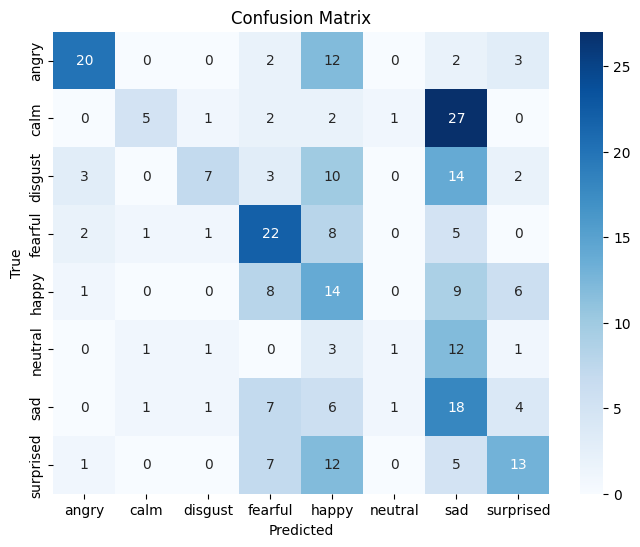

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
model.evaluate(X_test, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3597 - loss: 1.6255 


[1.6287052631378174, 0.3472222089767456]

In [ ]:
model.save("/content/drive/MyDrive/YAMNet_SER_model.h5")
with open("/content/drive/MyDrive/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model and label encoder saved to Drive.")
